# Fit the flux with a power law model

For this example, you need skyllh installed and the IceCube public 10 years point source data. Specify the correct paths in the `.env` file.

In [1]:
import icecube_flux
import numpy as np

Create the source object from icecube_flux. You specify the position in right ascension and declination in degrees. Name is optional, but can be used for storing data and plots. 

In [2]:
my_source = icecube_flux.Source(ra=77.35818516, dec=5.69314828, name="TXS 0506+056")

## Fitting the flux

Fit the flux. Specify the bounds on the spectral index gamma. If an analysis instance has not yet been created (like in this example), it will create an analysis instance. 

In [3]:
flux_norm, gamma = my_source.calculate_neutrino_flux(gamma_min=1, gamma_max=3.7)

calculating best fit flux
creating analysis


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 2683.55it/s]

[10.  3.] -2.1487238911707767


Print the fit parameter. We can calculate the flux with:

$$ \Phi = \mathrm{fluxnorm} \left( \frac{E}{1000~\mathrm{GeV}} \right)^\gamma, $$
and get units of (GeV s cm$^2$ sr)$^{-1}$.

In [4]:
flux_norm, gamma

(4.246381097274767e-15, 3.0)

In [5]:
my_source.flux_in_GeV, my_source.ns, my_source.gamma

(4.246381097274767e-15, 10.0, 3.0)

## Determining the valid energy range (see also [Appendix A2 in M. Karl, et al., MNRAS, 2023](https://academic.oup.com/mnras/article/526/1/661/7269217))

The power law itself extends indefinitely. We need to estimate from which true neutrino energies we actually saw the events. 

We have no Monte Carlo sample with which we could compare the top contributing events, so we have to use the smearing matrix. The smearing matrix includes a fractional count. This fractional count is the probability that an event is reconstructed with certain properties, given its true energy and declination:
Fractional_Counts = Events in $(E_{true}, Dec_{true}, E_{reco}, PSF, \sigma_{reco})$ / Events in $(E_{true}, Dec_{true})$. $PSF$ states the distance of the reconstructed position to the true neutrino origin. 

We need the distribution of true energy based on the reconstruction properties: $P(E_{true} | E_{reco}, \sigma_{reco}, \delta_{reco})$, always assuming a source flux $\Phi = \Phi_0 \times E^{-\gamma}$. Hence, $P(E_{true})$ should be thought of as $P(E_{true}|\Phi)$. We assume that the reconstructed declination is the same as the true neutrino declination.

With Bayes theorem:
$$P(E_{true} | E_{reco}, \sigma_{reco}, \delta_{reco}) = \frac{P(E_{reco}, \sigma_{reco}, \delta_{reco} | E_{true}) P(E_{true})}{P(E_{reco}, \sigma_{reco}, \delta_{reco})}. $$

* $P(E_{reco}, \sigma_{reco}, \delta_{reco} | E_{true})$ is given by the smearing matrix as the fractional counts $\frac{N_{reco, true E}}{N_{true E}}.$


* $P(E_{true})$ can be calculated with the effective area. The effective area, $A_{eff}$, yields the number of expected events, $N_{obs}$, for a given flux, $\Phi $, in the energy range $E_0$ to $E_1$ and during detection time $T$:

$$N_{obs} = \int _{E_0}^{E_1} \int_{t_0}^T \Phi(E) A_{eff}(E) dE dt.$$

The probability to get an event with true Energy, $E_{true}$, is $P(E_{true}) = \frac{N_{E_{true}}}{N_{all}}$. We assume $E_{true}$ lies within the energy bin with edges $E_0$ and $E_1$ of the effective area matrix:

$$P(E_{true}) = \frac{N_{E_{true}}}{N_{all}} = \frac{ \int _{E_0}^{E_1} \int_{t_0}^T \Phi(E) A_{eff}(E) dE dt } 
{\int _{E_{min}}^{E_{max}} \int_{t_0}^T \Phi(E) A_{eff}(E) dE dt}, $$

where the time integral is given by the total uptime of the detector in each respective data sample. 


* finally: $P(E_{reco}, \sigma_{reco}, \delta_{reco}) = \sum_{E_{true}} P(E_{reco}, \sigma_{reco}, \delta_{reco} | E_{true}) P(E_{true})$ and can be calculated with the two above quantities. 

With this, we can get $P(E_{true} | E_{reco}, \sigma_{reco}, \delta_{reco})$ and use each value as weight for the histogram. Then we can determine the central 90% limits of the true neutrino energy. 

With the above steps, we get $P(E_{true} | E_{reco}, \sigma_{reco}, \delta_{reco})$ for each sample. If we want to get one combined probability ofer all samples, we weigh each contribution with the the ratio of the sample effective area over the summed effective area of all samples (for a respective declination and true energy). We then scale each sample contribution with this factor. 

$$ \text{sample contribution} = \frac{\int _{E_0}^{E_1} A_{eff,sample}(E) dE}{\sum_{samples} \int _{E_0}^{E_1} A_{eff,sample}(E) dE}$$

Hence, each bin entry is $P(E_{true} | E_{reco}, \sigma_{reco}, \delta_{reco}) \times \text{sample contribution}$ and we can take the sum over all samples for each bin to get the true energy distribution.

The energy range of the fitted flux is then the central 90\% quantile of the true energy distribution.


In [6]:
log_emin, log_emax = my_source.get_correct_energy_range()
print("The flux is valid between {:.2f} GeV and {:.2f} GeV".format(10**log_emin, 10**log_emax))

The flux is valid between 398.11 GeV and 158489.32 GeV


## Get uncertainties based on likelihood. (This quantity is biased)

You can scan the likelihood and define the thresholds for 68% and 90% uncertainties (assuming Wilk's theorem). However, this quantity is biased (as is the best-fit result of the neutrino flux) and does not work proberly for low best-fit fluxes (low number of signal neutrinos ns). To get a more accurate estimation of uncertainties that also works for low flux values, use Feldman-Cousins interval estimation.  

In [30]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

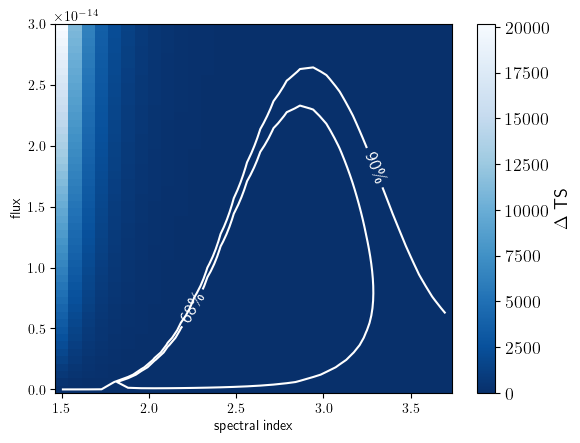

In [38]:
gamma_errs, flux_errs = my_source.get_flux_uncertainties_llh_scan(gamma_min=1.5, gamma_max=3.7, 
                                                                  flux_min_factor=1, flux_max_factor=6,
                                                                  show_plot=True, save_plot=False)

In [9]:
energies = np.logspace(log_emin, log_emax)

In [18]:
flux, bowtie_low, bowtie_high = my_source.get_flux_with_uncert(energies, use_llh_scan=True)

[]

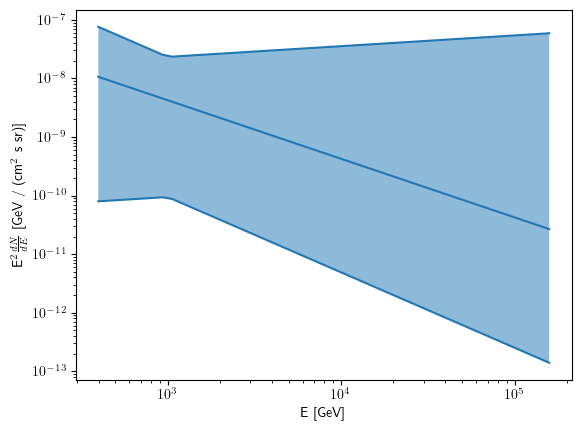

In [37]:
plt.plot(energies, flux*energies**2)

plt.plot(energies, bowtie_low*energies**2, color="tab:blue")
plt.plot(energies, bowtie_high*energies**2, color="tab:blue")
plt.fill_between(energies, bowtie_low*energies**2, bowtie_high*energies**2, alpha=0.5)
plt.ylabel(r"E$^2 \frac{dN}{dE}$ [GeV / (cm$^2$ s sr)]")
plt.xlabel("E [GeV]")
plt.loglog()